# Project 2

In [8]:
#Code for the Franke function
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn import linear_model 
from sklearn.linear_model import Lasso

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed, randint 
from numpy.random import normal, uniform
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import seaborn as sns

# Make data.
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)
x, y = np.meshgrid(x,y)


def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

z = FrankeFunction(x,y)
i = np.random.shuffle((np.arange(z.shape[0])))


x = x.flatten() 
y = y.flatten() 
z = z.flatten()
x,y,z = shuffle(x,y,z)

X = np.ones(len(z))


for i in range(1,5):
    X = np.vstack((X.T,x**i,y**i,(x*y)**i)).T

scaler = StandardScaler(with_mean = True, with_std = False)
X = scaler.fit_transform(X)
X.T[0][:] = np.ones(len(z))

## Optimal betas and R2 score with normal linear regression

In [120]:
U, σ, vT = np.linalg.svd(X, full_matrices=False)
    
beta_l = (vT.T @ np.linalg.inv(np.diag(σ)) @ U.T @ z)
    
model_linear= X @ beta_l
    
r2 = r2_score(z,model_linear)


print('Results by linear regression', r2)

Results by linear regression 0.9426134884557795


## Optimal betas and R2 score with beta rigde

In [121]:
X_train, X_test, z_train,  z_test = train_test_split(X,z,test_size = 0.25)

X_ = np.delete(X_train,0,1)
b0 = np.mean(z_train)
z_ = z_train-b0

lamb = 4.094078085004049*(10**(-5))
  
U, σ, vT = np.linalg.svd(X_, full_matrices=False)
    
        
# here we calculate beta values
penalty = np.linalg.inv(np.diag(σ)**2 + lamb) @ np.diag(σ)
        
beta_ridge = vT.T @ penalty @ U.T @ z_
        
beta_ridge = np.append(b0,beta_ridge)
        
r2 = r2_score(z_test,X_test @ beta_ridge)
     
print(r2)
print()

0.9308049301376489



## Stocastic gradient descent

In [160]:
def sdg(gradient,beta,learning_rate,epochs,batches,X,z,lamb):
    
    step = int(len(z)/batches)
    eta = learning_rate
    gradient_values = np.zeros((epochs,len(beta)))
    gradient_lambda = np.zeros((epochs,len(beta)))
    
    #for each epoch
    for i in range(epochs):
        X,z = shuffle(X,z)
        
        start = 0
            #for each batch
        for j in range(batches):
            g = gradient(beta,X[start:start+step,:],z[start:start+step],lamb) # skaled decomposed gradient
            g[0][0] /= 10
            
            gradient_values[i] += 10000*g[0]/batches
            gradient_lambda[i] += g[1]/batches
            
                
            beta += eta*g[0]*10000 # because the gradient is scaled
            beta -= eta*g[1]
            
            start += step
    return [beta,gradient_values,gradient_lambda]

## Stocastic gradient descent with momentum 

In [208]:
def sdg_momentum(gradient,beta,learning_rate,epochs,batches,X,z,lamb,alpha,goal):
    
    momentum = np.zeros(len(beta))
    step = int(len(z)/batches)
  
    for i in range(epochs):
        X,z = shuffle(X,z)
        start = 0
        for j in range(batches):
            g = gradient(beta,X[start:start+step,:],z[start:start+step],lamb)
            g[0][0] /= 10
            beta = beta + learning_rate*(g[0]*10000-g[1]) + momentum * alpha
            momentum = learning_rate*g[0]*10000 + momentum * alpha  # here we save the momentum
            start += step
         
        # When we are within 1 percent of goal values
        if (np.mean(np.abs((goal-beta)/goal)) < 0.01): 
            return beta,i
    return beta,i

## Adaptive Gradient Algorithm

In [202]:
def adagrad(gradient,beta,learning_rate,epochs,batches,X,z,lamb):
    
    step = int(len(z)/batches)
    eta = learning_rate
    small_value = 1*np.exp(-7)
    square_values = np.zeros(len(beta))
    
    for i in range(epochs):
        X,z = shuffle(X,z)
        
        start = 0
        for j in range(batches):
            g = gradient(beta,X[start:start+step,:],z[start:start+step],lamb)
            g[0][0] /= 10
            square_values += np.square(g[0]+g[1])
                
            beta += eta*(g[0]+g[1]) / np.sqrt(square_values + small_value)
            
            start += step
            
    return beta

# works perfectly but not used in project

### The gradient for regression

In [221]:
def gradient(beta,X,z,lamb):
    
    beta_s = np.copy(beta)
    beta_s[0] = 0
    return [(X.T)@(z-X@beta)/len(X) ,- 2*lamb*beta_s]

def gradient_scaled(beta,X,z,lamb):
  
    beta_s = np.copy(beta)
    beta_s[0] = 0
    
    X_  = np.copy(X)/10000
    z_ = np.copy(z)/10000
    
    return [(X_.T)@(z_-X_@beta) ,lamb*beta_s]

## Heatmap for batches and learning rate

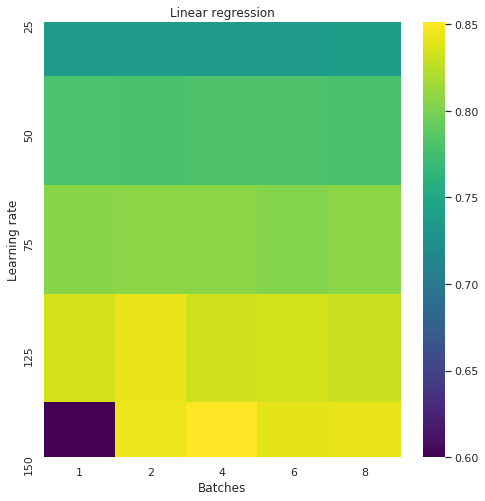

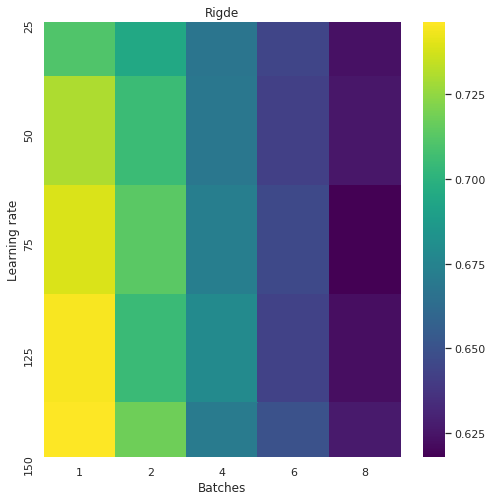

In [222]:
import seaborn as sns
# Here i define the values 

beta = np.random.normal(0,0.001,len(beta_l))
learning_rate = [25,50,75,125,150]
batches = [1,2,4,6,8]
epochs = 500
lamb = 4.094078085004049*(10**(-5))



sns.set()

R2_for_linear = np.zeros((len(learning_rate), len(batches)))
R2_for_rigde = np.zeros((len(learning_rate), len(batches)))




for i in range(len(learning_rate)):
    for j in range(len(batches)):
        
        
       
        beta_lin = sdg(gradient_scaled,np.copy(beta),learning_rate[i],epochs,batches[j],X,z,0)
        beta_rig = sdg(gradient_scaled,np.copy(beta),learning_rate[i],epochs,batches[j],X_train,z_train,lamb)
        
      
        R2_for_linear[i][j] = r2_score(X@beta_lin[0],z)
        R2_for_rigde[i][j] = r2_score(X_test@beta_rig[0],z_test)

        
fig, ax = plt.subplots(figsize = (8, 8))
sns.heatmap(R2_for_linear,xticklabels=batches, yticklabels= learning_rate, ax=ax, cmap="viridis",vmin = 0.6)
ax.set_title("Linear regression")
ax.set_ylabel("Learning rate")
ax.set_xlabel("Batches")
plt.show()

fig, ax = plt.subplots(figsize = (8, 8))
sns.heatmap(R2_for_rigde, ax=ax, cmap="viridis" ,xticklabels=batches, yticklabels= learning_rate)
ax.set_title("Rigde")
ax.set_ylabel("Learning rate")
ax.set_xlabel("Batches")
plt.show()

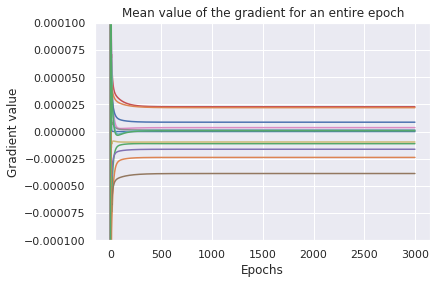

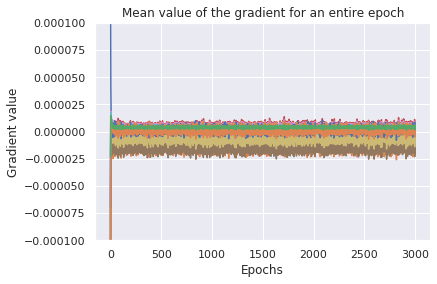

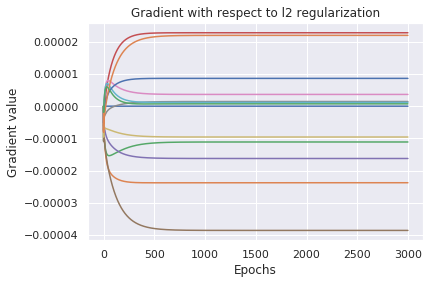

Gradient decomposition
[ 0.00095541 -0.02481894 -0.01202763  0.02331882 -0.01679391 -0.03946519
  0.00406984  0.00136389 -0.00992867  0.00146308  0.00886018  0.02213894
  0.00093852]
[ 0.         -0.02352825 -0.01142683  0.02207533 -0.01591354 -0.03737063
  0.00387523  0.00128462 -0.00940797  0.00139729  0.00839121  0.02094702
  0.00090021]


[ 0.00015918 -0.01470071 -0.01283687  0.00453505 -0.00878695 -0.01527667
  0.00500885 -0.00207908 -0.00685521  0.00465498  0.00152846  0.00130854
  0.00393481]
[ 0.         -0.01456906 -0.01272325  0.00449197 -0.00870864 -0.01514028
  0.00496384 -0.00206098 -0.00679459  0.00461245  0.00151416  0.00129573
  0.00389949]


In [220]:
epochs = 3000
beta = np.random.normal(0,0.001,len(beta_l))
beta_rig_b1 = sdg(gradient_scaled,np.copy(beta),150,epochs,1,X_train,z_train,lamb)
beta_rig_b6 = sdg(gradient_scaled,np.copy(beta),150,epochs,6,X_train,z_train,lamb)

plt.plot(np.arange(epochs),beta_rig_b1[1])
plt.ylim(-0.0001,0.0001)
plt.title('Mean value of the gradient for an entire epoch')
plt.xlabel('Epochs')
plt.ylabel('Gradient value')
plt.show()

plt.plot(np.arange(epochs),beta_rig_b6[1])
plt.title('Mean value of the gradient for an entire epoch')
plt.ylim(-0.0001,0.0001)
plt.xlabel('Epochs')
plt.ylabel('Gradient value')
plt.show()

plt.plot(np.arange(epochs),beta_rig_b1[2], label='Adaptive stocastic gradient decent')
plt.xlabel('Epochs')
plt.title('Gradient with respect to l2 regularization')
plt.xlabel('Epochs')
plt.ylabel('Gradient value')
plt.show()

print("Gradient decomposition")
print(np.mean(beta_rig_b1[1], axis = 0)*1000)
print(np.mean(beta_rig_b1[2], axis = 0)*1000)
print('\n')
print(np.mean(beta_rig_b6[1], axis = 0)*1000)
print(np.mean(beta_rig_b6[2], axis = 0)*1000)

## Effects of momentum for stocastic gradient decent

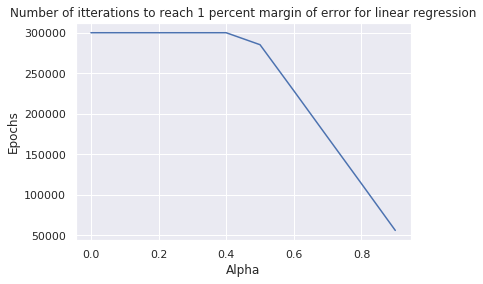

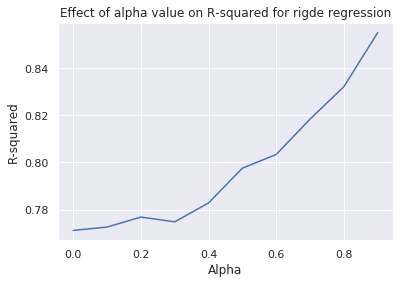

In [223]:
beta = np.random.normal(0,0.001,len(beta_l))
learning_rate = 250
batches = 2
epochs = 300000

alphas = np.linspace(0,0.9,10)
itterations = np.zeros(len(alphas))
r2_alphas_rigde = np.zeros(len(alphas))

for j in range(len(alphas)):
    
    beta_lin = sdg_momentum(gradient_scaled,np.copy(beta),learning_rate,epochs,batches,X,z,0,alphas[j],beta_l)
    itterations[j] = beta_lin[1]

epochs = 100000
for k in range(len(alphas)):
    
    beta_rig = sdg_momentum(gradient_scaled,np.copy(beta),learning_rate,epochs,batches,X_train,z_train,lamb,alphas[k],beta_ridge)
    r2_alphas_rigde[k] = r2_score(z_test,X_test@beta_rig[0])

plt.plot(alphas,itterations, label='Momentum sgd')
plt.title('Number of itterations to reach 1 percent margin of error for linear regression')
plt.ylabel('Epochs')
plt.xlabel('Alpha')
plt.show()

plt.plot(alphas,r2_alphas_rigde, label='Momentum sgd')
plt.title('Effect of alpha value on R-squared for rigde regression')
plt.ylabel('R-squared')
plt.xlabel('Alpha')
plt.show()

In [224]:
print('Rigde regression')
print(beta_ridge[:5])
print(beta_rig[0][:5])
print('\n')

print('Linear regresstion')
print(beta_l[:5])
print(beta_lin[0][:5])

print('\nWe see that rigde decreases the beta values with both gradient desent')
print('More importantly we se that momentum stocastic gradient decent has almost obtained the ideal values')

Rigde regression
[  0.43762367   4.16990483   3.92034654  -2.97523217 -19.53135748]
[ 0.43405696 -0.66016906  0.2401067   1.01172284 -0.74211299]


Linear regresstion
[  0.42545609   4.21688561   4.26018109  -2.91900123 -20.00337064]
[  0.42564257   4.16792827   4.22052522  -2.89558211 -19.90889352]

We see that rigde decreases the beta values with both gradient desent
More importantly we se that momentum stocastic gradient decent has almost obtained the ideal values


## Graphs comparing how the beta values change

In [228]:
beta = np.random.normal(0,0.001,len(beta_l))

betas_sgd = np.zeros((300,len(beta)))
betas_momentum = np.zeros((300,len(beta)))
betas_ada = np.zeros((300,len(beta)))

betas_sgd_rigde = np.zeros((300,len(beta)))
betas_momentum_rigde = np.zeros((300,len(beta)))
betas_ada_rigde = np.zeros((300,len(beta)))

learning_rate = 250
batches = 2
epochs = 30000
lamb = 4.094078085004049*(10**(-5))

betas_ada[0] = np.copy(beta)
betas_sgd[0] =np.copy(beta)
betas_momentum[0] =np.copy(beta)

betas_ada_rigde[0] = np.copy(beta)
betas_sgd_rigde[0] = np.copy(beta)
betas_momentum_rigde[0] =np.copy(beta)

# I save the betas from 300 equally spaced out steps

for i in range(0,299):
    
    #betas_ada[i+1] = adagrad(gradient_scaled,betas_ada[i],learning_rate,int(epochs/300),batches,X,z,0)
        
    betas_sgd[i+1] = sdg(gradient_scaled,betas_sgd[i],learning_rate,int(epochs/300),batches,X,z,0)[0]
    
    betas_momentum[i+1] = sdg_momentum(gradient_scaled,betas_momentum[i],learning_rate,int(epochs/300),batches,X,z,0,7/10,beta_l)[0]

for i in range(0,299):
    
    #betas_ada_rigde[i+1] = adagrad(gradient_scaled,betas_ada_rigde[i],learning_rate,int(epochs/300),batches,X,z,lamb)
        
    betas_sgd_rigde[i+1] = sdg(gradient_scaled,betas_sgd_rigde[i],learning_rate,int(epochs/300),batches,X,z,lamb)[0]
    
    betas_momentum_rigde[i+1] = sdg_momentum(gradient_scaled,betas_momentum_rigde[i],learning_rate,int(epochs/300),batches,X,z,lamb,7/10,beta_ridge)[0]

   

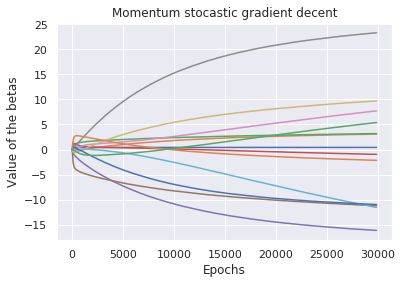

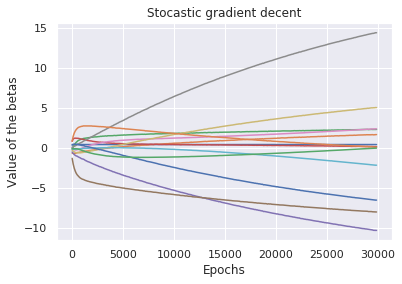

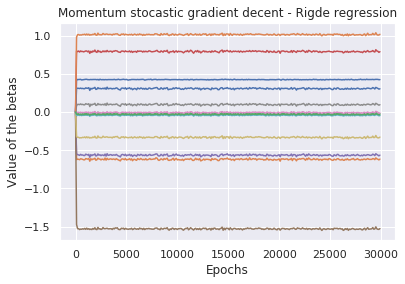

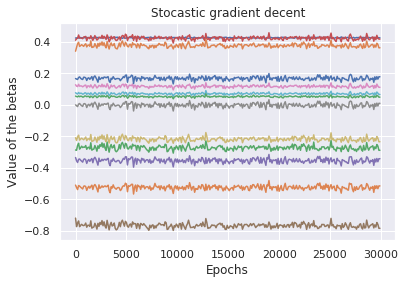

In [229]:
a = np.arange(300)*int(epochs/300)

plt.plot(a,betas_momentum, label='Momentum sgd')
plt.title('Momentum stocastic gradient decent')
plt.xlabel('Epochs')
plt.ylabel('Value of the betas')
plt.show()

plt.plot(a,betas_sgd, label='Stocastic gradient decent')
plt.xlabel('Epochs')
plt.ylabel('Value of the betas')
plt.title('Stocastic gradient decent')
plt.show()

plt.plot(a,betas_momentum_rigde, label='Momentum sgd')
plt.title('Momentum stocastic gradient decent - Rigde regression')
plt.xlabel('Epochs')
plt.ylabel('Value of the betas')
plt.show()

plt.plot(a,betas_sgd_rigde, label='Stocastic gradient decent -  Ridge regression')
plt.xlabel('Epochs')
plt.ylabel('Value of the betas')
plt.title('Stocastic gradient decent')
plt.show()

#plt.plot(a,betas_ada, label='Adaptive stocastic gradient decent')
#plt.xlabel('Epochs')
#plt.title('Adaptive stocastic gradient decent')
#plt.show()
#plt.plot(a,betas_ada_rigde, label='Adaptive stocastic gradient decent - Ridge regression')
#plt.xlabel('Epochs')
#plt.title('Adaptive stocastic gradient decent- Ridge regression')
#plt.show()

# A simple neural network

In [1208]:
def sigmoid(x):
    return np.exp(x)/(1+np.exp(x))

In [1424]:
def d_sigmoid(x):
    return ((1/(1 + np.exp(-x))) * (1-1/(1 + np.exp(-x))))

In [1212]:
def swich(x,beta):
    return x/(1 + np.exp(-beta*x))

In [1213]:
def Rectified_Linear_Unit(x):
    for i in range(len(X)):
        if (x[i] < 0):
            x[i] = 0
    return x

In [1378]:
class NeuralNetwork:
    def __init__(
            self,
            X_data,
            Y_data,
            n_hidden_neurons=[2,1,1],
            n_categories=1,
            epochs=10,
            batch_size=100,
            eta=0.1,
            lmbd=0.0):
        
        
        #this is the full data
        self.X_data_full = X_data
        self.Y_data_full = Y_data
        
        
        
        #this is for the arcitecture
        self.n_inputs = X_data.shape[0]
        self.n_features = X_data.shape[1]
        
        self.n_hidden_neurons = n_hidden_neurons
        self.nr_of_layers = len(self.n_hidden_neurons)
        self.n_categories = n_categories
        
        # Architecture of the intire network
        assert self.n_hidden_neurons[0] == self.n_features
        assert self.n_hidden_neurons[self.nr_of_layers-1] == self.n_categories
        
        print("self.n_inputs", self.n_inputs)
        print("self.n_features", self.n_features)
        
        
        # this is for training
        self.epochs = epochs
        self.batch_size = batch_size
        self.iterations = self.n_inputs // self.batch_size
        self.eta = eta
        self.lmbd = lmbd
        
        
       
        
        data_indices = np.arange(self.n_inputs)
        
        self.first = True
        
        self.X_data = self.X_data_full
        self.Y_data = self.Y_data_full 
        
        self.create_biases_and_weights()

        self.train()
    

    def create_biases_and_weights(self):
        
        mu = 1
        sigma = 0.25*mu
        
        self.weights = []
        self.bias = []
        
        for i in range(0,self.nr_of_layers-1):
            # one bias for each node in next layer 
            # weights of n x m between layers with n and m nodes
            self.bias.append(np.zeros(int(self.n_hidden_neurons[i+1])) + 0.00001)
            self.weights.append(np.random.rand(int(self.n_hidden_neurons[i]), int(self.n_hidden_neurons[i+1])))

        
        # we adjust the bias
        self.feed_forward()
            
    def feed_forward(self):
        
        
        
        self.start_and_sigmoid = [] #start and sigmoid and end
        self.product_and_bias = [] 
        self.start_and_sigmoid.append(self.X_data)
        
        for i in range(self.nr_of_layers-1):
            
            self.product_and_bias.append(np.matmul(self.start_and_sigmoid[i] , (self.weights[i])) + self.bias[i])
            
            self.start_and_sigmoid.append(sigmoid(self.product_and_bias[i]))
              
            # adjust bias to improve model
            if (self.first == True):
                self.bias[i] += (0.5-np.mean(self.product_and_bias[-1]))
        
        self.first = False
        



    def backpropagation(self):
        
        gradient_weights = [] # derivative of the costfunction with respect to weights
        gradient_bias = [] # derivatative of the costfunction with respect to weights
        
        error = [None] * (len(self.weights))
        
        #if we add a activation function to the last node, add the derv
        error[-1] = (self.Y_data - self.start_and_sigmoid[-1].T)*(self.start_and_sigmoid[-1]*(1-self.start_and_sigmoid[-1])).T
        
         
        # derivative costfuntion with respect to layer l - like the rapport
        for i in reversed(range(len(error)-1)):
            error[i] = (self.weights[i+1]@error[i+1])*(self.start_and_sigmoid[i+1]*(1-self.start_and_sigmoid[i+1])).T
            
        
        for i in range(len(error)): 
            
            self.bias[i] += self.eta * np.mean(error[i], axis = 1)
            self.weights[i] += self.eta * self.start_and_sigmoid[i].T@error[i].T
        
    
    def predict(self, X, z):
        
        self.start_and_sigmoid = [] #start and sigmoid and end
        self.product_and_bias = [] 
        self.start_and_sigmoid.append(X)
        
        for i in range(self.nr_of_layers-1):
            
            self.product_and_bias.append(np.matmul(self.start_and_sigmoid[i] , (self.weights[i])) + self.bias[i])
            
            self.start_and_sigmoid.append(sigmoid(self.product_and_bias[i]))
            
        
        return self.start_and_sigmoid[-1]
    
    def train(self):
        data_indices = np.arange(self.n_inputs)

        for i in range(self.epochs):
            for j in range(self.iterations):
                # pick datapoints with replacement
                chosen_datapoints = np.random.choice(
                    data_indices, size=self.batch_size, replace=False
                )

                # minibatch training data
                self.X_data = self.X_data_full[chosen_datapoints]
                self.Y_data = self.Y_data_full[chosen_datapoints]
                
                #print("backprop")
                self.feed_forward()
                self.backpropagation()
                
                
    def sigmoid(X):
        return [1/(1 + np.exp(-np.sum(X, axis = 1)))]

In [1381]:
x,y,z = shuffle(x,y,z)
a = 350
X = np.vstack((x[0:a],y[0:a])).T
Y = z[0:a]


n_hidden_neurons= [2,30,15,1]
n_categories=1
epochs = 5000
batch_size=100
eta=0.1
lmbd=0.0


n = NeuralNetwork(X,Y,n_hidden_neurons, n_categories,epochs,batch_size,eta,lmbd)

X_test = np.vstack((x[a:int(a+50)],y[a:int(a+50)])).T
z_test = z[a:int(a+50)]
model =n.predict(X_test,z_test)

from sklearn.metrics import r2_score
print("The R2 score shows that the network is working well")
print(r2_score(z_test,model))


self.n_inputs 350
self.n_features 2
The R2 score shows that the network is working well
0.9446396643086362


## A neural network with multiple functions and momentum

In [32]:
class NeuralNetwork_change:
    def __init__(
            self,
            X_data,
            Y_data,
            n_hidden_neurons=[2,1,1],
            layer_functions =['None','Sigmoid','Sigmoid'],
            n_categories=1,
            epochs=10,
            batch_size=100,
            eta=0.1,
            lmbd=0.0,
            alpha = 0.0):
        
        
        #this is the full data
        self.X_data_full = X_data
        self.Y_data_full = Y_data
        
        
        
        #this is for the arcitecture
        self.n_inputs = X_data.shape[0]
        self.n_features = X_data.shape[1]
        
        self.n_hidden_neurons = n_hidden_neurons
        self.nr_of_layers = len(self.n_hidden_neurons)
        self.n_categories = n_categories
        self.layer_functions = layer_functions
        
        assert self.n_hidden_neurons[0] == self.n_features
        assert self.n_hidden_neurons[self.nr_of_layers-1] == self.n_categories
        assert len(self.layer_functions) == self.nr_of_layers
        
        #print("self.n_inputs", self.n_inputs)
        #print("self.n_features", self.n_features)
        
        
        # this is for training
        self.epochs = epochs
        self.batch_size = batch_size
        self.iterations = self.n_inputs // self.batch_size
        self.eta = eta
        self.lmbd = lmbd
        self.alpha = alpha
        
        self.function_data = []   
        
        data_indices = np.arange(self.n_inputs)
        
        self.first = True
        
        self.X_data = self.X_data_full
        self.Y_data = self.Y_data_full 
        
        self.create_biases_and_weights()
        
        self.momentum_bias  = np.copy(self.bias) - np.copy(self.bias)
        self.momentum_weights = np.copy(self.weights) - np.copy(self.weights)
        self.train()
    

    def create_biases_and_weights(self):
        
        mu = 1
        sigma = 0.25*mu
        
        self.weights = []
        self.bias = []
        self.start_and_sigmoid = [] #start and sigmoid and end
        self.product_and_bias = [] 
        self.start_and_sigmoid.append(self.X_data)
        
        for i in range(0,self.nr_of_layers-1):
            
            self.bias.append(np.zeros(int(self.n_hidden_neurons[i+1])) + 0.00001)
            self.weights.append(np.random.rand(int(self.n_hidden_neurons[i]), int(self.n_hidden_neurons[i+1])))
            
            # divide the weight by what the max value of the next layer would be, add change bias so mean is .5
            self.weights[-1] /= np.max(np.matmul(self.start_and_sigmoid[i] , (self.weights[i])) + self.bias[i])
            self.bias[-1] += (0.5-np.mean(np.matmul(self.start_and_sigmoid[i] , (self.weights[i])) + self.bias[i]))
            
            self.product_and_bias.append(np.matmul(self.start_and_sigmoid[i] , (self.weights[i])) + self.bias[i])
            self.start_and_sigmoid.append(self.call_f(False,self.layer_functions[i+1],self.product_and_bias[i]))
            
        #self.feed_forward()
        
        
            
    def feed_forward(self):
        
        
        
        self.start_and_sigmoid = [] #start and sigmoid and end
        self.product_and_bias = [] 
        self.start_and_sigmoid.append(self.X_data)
        
        for i in range(self.nr_of_layers-1):
            
            self.product_and_bias.append(np.matmul(self.start_and_sigmoid[i] , (self.weights[i])) + self.bias[i])
            # calls the correct function
            self.start_and_sigmoid.append(self.call_f(False,self.layer_functions[i+1],self.product_and_bias[i]))

        
        


    def backpropagation(self):
        
        gradient_weights = [] # derivative of the costfunction with respect to weights
        gradient_bias = [] # derivatative of the costfunction with respect to bias
        
        error = [None] * (len(self.weights))
        
       
        # multiplies costfunction derivative with chain derivative. saves in an array backwords
        error[-1] = (self.Y_data - self.start_and_sigmoid[-1].T)*self.call_f(True,self.layer_functions[-1],self.product_and_bias[-1]).T
        for i in reversed(range(len(error)-1)):
           
            error[i] = (self.weights[i+1]@error[i+1])*self.call_f(True,self.layer_functions[i+1],self.product_and_bias[i]).T
            
        
        
        for i in range(len(error)): 
            
            # alpha becomes percentage used
            self.momentum_bias[i] *= self.alpha
            self.momentum_weights[i] *= self.alpha
            
            self.bias[i] += self.eta * np.mean(error[i], axis = 1) + self.momentum_bias[i]
            self.weights[i] += self.eta * self.start_and_sigmoid[i].T@error[i].T + self.momentum_weights[i]
            
            # we add to momentum
            self.momentum_bias[i] += np.mean(error[i], axis = 1)
            self.momentum_weights[i] += self.start_and_sigmoid[i].T@error[i].T

        if self.lmbd > 0.0:
            for i in range(0,len(self.bias)):
                self.bias[i] -= self.lmbd * self.bias[i]
                self.weights[i] -= self.lmbd * self.weights[i]
        
    
    def predict(self, X, z):
        
        self.start_and_sigmoid = [] #start and sigmoid and end
        self.product_and_bias = [] 
        self.start_and_sigmoid.append(X)
        
        for i in range(self.nr_of_layers-1):
            
            self.product_and_bias.append(np.matmul(self.start_and_sigmoid[i] , (self.weights[i])) + self.bias[i])
            
            self.start_and_sigmoid.append(self.call_f(False,self.layer_functions[i+1],self.product_and_bias[i]))
            
        return self.start_and_sigmoid[-1]
    
    def train(self):
        data_indices = np.arange(self.n_inputs)

        for i in range(self.epochs):
            for j in range(self.iterations):
                # pick datapoints with replacement
                chosen_datapoints = np.random.choice(
                    data_indices, size=self.batch_size, replace=False
                )

                # minibatch training data
                self.X_data = self.X_data_full[chosen_datapoints]
                self.Y_data = self.Y_data_full[chosen_datapoints]
                
                self.feed_forward()
                self.backpropagation()
                
                
    def sigmoid(X):
        return [1/(1 + np.exp(-np.sum(X, axis = 1)))]
    
    def call_f(self,derivative,name,x):
        
        if (name == 'Sigmoid'):
            if derivative:
                return ((1/(1 + np.exp(-x))) * (1-1/(1 + np.exp(-x))))
            return np.exp(x)/(1+np.exp(x)) # it can be written 2 ways
         
            
        if (name == 'None'):
            if derivative:
                return np.ones(x.shape)
            return x
        
        
        if (name == 'Tanh'):
            k = np.tanh(x)
            if derivative:
                return 1.0-k**2
            return k
        
        
        if (name == 'Swich'):
            
            s = x/(1-np.exp(-x))
            
            if derivative:
                return s + 1/(1-np.exp(-x))*(1-s)
                
            return s
        
        
        if (name == 'Relu'):
            xdot = np.copy(x)
            if derivative:
                xdot[xdot<0] = 0
                xdot[xdot>0] = 1
                return xdot
            
            xdot[xdot<0] = 0
            return xdot
        
        if (name == 'LeakyRelu'):
            x2 = np.copy(x)
            if derivative:
                x2[x2<0] = 0.01
                x2[x2>0] = 1
                return x2
            
            x2[x2<0] *= 0.01
            return x2
        
        print("Error")
        return 
            
            

### One good and one bad combination

In [6]:
# Here i make test and trainingdata
x,y,z = shuffle(x,y,z)
X = np.vstack((x,y)).T

X_train , X_test , z_train, z_test = train_test_split(X,z, test_size = 0.15)



n_hidden_neurons= [2,30,15,8,1]
layer_functions1 = ['None','Sigmoid','Sigmoid','Sigmoid','Swich']
layer_functions2 = ['None','Relu','LeakyRelu','Relu','LeakyRelu']
n_categories=1
epochs = 5000
batch_size=100
eta=0.1
lmbd=0.00001


new = NeuralNetwork_change(X_train,z_train,n_hidden_neurons,layer_functions1, n_categories,epochs,batch_size,eta,lmbd,0.0)
new_relu = NeuralNetwork_change(X_train,z_train,n_hidden_neurons,layer_functions2, n_categories,15000,batch_size,0.005,lmbd,0.0)

model = new.predict(X_test,z_test)
model2 =new_relu.predict(X_test,z_test)


from sklearn.metrics import r2_score
print("The R2 score shows that the network is working well, but not for all combinations")
print(r2_score(z_test,model))
print(r2_score(z_test,model2))


The R2 score shows that the network is working well, but not for all combinations
0.9353096337626395
0.7187180505708126


### Heatmap

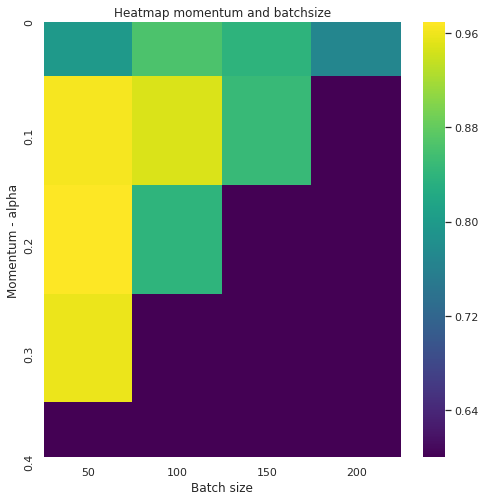

In [36]:
epochs = 2000
batch_sizes=[50,100,150,200]
alphas = [0,0.1,0.2,0.3,0.4]
eta=0.1
sns.set()

r_squared = np.zeros((len(alphas), len(batch_sizes)))


for i in range(len(alphas)):
    for j in range(len(batch_sizes)):
         
        new = NeuralNetwork_change(X_train,z_train,n_hidden_neurons,layer_functions1, n_categories,epochs,batch_sizes[j],eta,lmbd,alphas[i])
        r_squared[i][j] = r2_score(z_test,new.predict(X_test,z_test))
     

        
fig, ax = plt.subplots(figsize = (8, 8))
sns.heatmap(r_squared,xticklabels=batch_sizes, yticklabels= alphas, ax=ax, cmap="viridis",vmin = 0.6)
ax.set_title("Heatmap momentum and batchsize")
ax.set_ylabel("Momentum - alpha")
ax.set_xlabel("Batch size")
plt.show()


## Four good combinations

In [12]:
epochs = 5000
batch_size = 100
import pandas as pd

data = [['None','Sigmoid','Sigmoid','Tanh','Sigmoid'],['None','Sigmoid','Sigmoid','Sigmoid','Sigmoid'],
       ['None','Tanh','Tanh','Tanh','Sigmoid'],['None','Sigmoid','None','Sigmoid','Sigmoid']]

for l in data:
    
    p = NeuralNetwork_change(X_train,z_train,n_hidden_neurons,l, n_categories,epochs,batch_size,eta,lmbd,0.0)
    model = p.predict(X_test,z_test)
    l.append(r2_score(z_test,model))
    
df = pd.DataFrame(data, columns = ['l1','l2','l3','l4','l5','R2'])

print(df)

     l1       l2       l3       l4       l5        R2
0  None  Sigmoid  Sigmoid     Tanh  Sigmoid  0.923150
1  None  Sigmoid  Sigmoid  Sigmoid  Sigmoid  0.951354
2  None     Tanh     Tanh     Tanh  Sigmoid  0.981609
3  None  Sigmoid     None  Sigmoid  Sigmoid  0.900839


# Regularization

In [37]:
lambs = np.linspace(0,0.00002,7)
epochs = 10000
batch_size=100
best_combo = ['None','Tanh','Tanh','Tanh','Sigmoid']
data2 = [[],[]]
for lmbd in lambs:
    
    lambda_network = NeuralNetwork_change(X_train,z_train,n_hidden_neurons,best_combo, n_categories,epochs,batch_size,eta,lmbd,0)
    model = lambda_network.predict(X_test,z_test)
    model_training = lambda_network.predict(X_train,z_train)
    
    data2[0].append(r2_score(z_train,model_training))
    data2[1].append(r2_score(z_test,model))
    
df = pd.DataFrame(data2, columns = lambs)
print(df)

   0.000000  0.000003  0.000007  0.000010  0.000013  0.000017  0.000020
0  0.978664  0.981691  0.987236  0.983497  0.985904  0.985072  0.985785
1  0.982914  0.981214  0.990105  0.983630  0.987224  0.986136  0.988744


In [94]:
x,y,z = shuffle(x,y,z)
X = np.vstack((x,y)).T

X_train , X_test , z_train, z_test = train_test_split(X,z, test_size = 0.25)

lambs = [0,0.000006,0.000015]
epochs = [3000,1000,1000,1000,1000,1000,1000]
batch_size=100
best_combo = ['None','Tanh','Tanh','Tanh','Sigmoid']



#test data
lists  = [[],[],[],[],[],[]]


for e in epochs:
    
    if (e == epochs[0]):
        n1 = NeuralNetwork_change(X_train,z_train,n_hidden_neurons,best_combo, n_categories,e,batch_size,eta,lambs[0])
        n2 = NeuralNetwork_change(X_train,z_train,n_hidden_neurons,best_combo, n_categories,e,batch_size,eta,lambs[1])
        n3 = NeuralNetwork_change(X_train,z_train,n_hidden_neurons,best_combo, n_categories,e,batch_size,eta,lambs[2])
    
    else:
        n1.epochs = e
        n2.epochs = e
        n3.epochs = e
        n1.train()
        n2.train()
        n3.train()
    
    lists[0].append(r2_score(z_test, n1.predict(X_test,0)))
    lists[1].append(r2_score(z_train, n1.predict(X_train,0)))
                    
    lists[2].append(r2_score(z_test, n2.predict(X_test,0)))
    lists[3].append(r2_score(z_train, n2.predict(X_train,0)))
                    
    lists[4].append(r2_score(z_test, n3.predict(X_test,0)))
    lists[5].append(r2_score(z_train, n3.predict(X_train,0)))
    

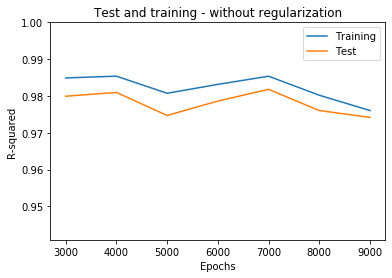

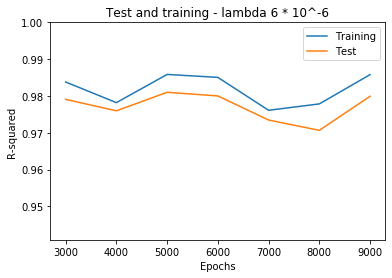

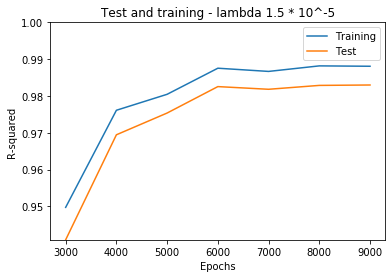

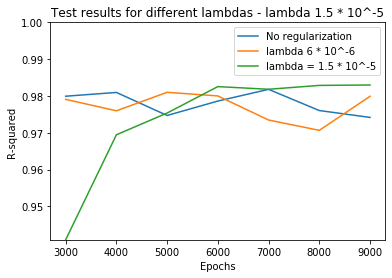

In [99]:
minimum = np.min(lists)
plt.plot(np.cumsum(epochs),lists[1], label='Training')
plt.plot(np.cumsum(epochs),lists[0], label='Test')
plt.xlabel('Epochs')
plt.ylabel('R-squared')
plt.title('Test and training - without regularization')
plt.ylim((minimum,1))
plt.legend()
plt.show()

plt.plot(np.cumsum(epochs),lists[3], label='Training')
plt.plot(np.cumsum(epochs),lists[2], label='Test')
plt.xlabel('Epochs')
plt.ylabel('R-squared')
plt.title('Test and training - lambda 6 * 10^-6')
plt.ylim((minimum,1))
plt.legend()
plt.show()

plt.plot(np.cumsum(epochs),lists[5], label='Training')
plt.plot(np.cumsum(epochs),lists[4], label='Test')
plt.xlabel('Epochs')
plt.ylabel('R-squared')
plt.title('Test and training - lambda 1.5 * 10^-5')
plt.ylim((minimum,1))
plt.legend()
plt.show()

plt.plot(np.cumsum(epochs),lists[0], label='No regularization')
plt.plot(np.cumsum(epochs),lists[2], label='lambda 6 * 10^-6')
plt.plot(np.cumsum(epochs),lists[4], label='lambda = 1.5 * 10^-5')
plt.xlabel('Epochs')
plt.ylabel('R-squared')
plt.title('Test results for different lambdas')
plt.ylim((minimum,1))
plt.legend()
plt.show()


# Classification 

In [558]:
class Classification_Network:
    def __init__(
            self,
            X_data,
            Y_data,
            n_hidden_neurons=[2,1,1],
            layer_functions =['None','Sigmoid','Softmax'],
            n_categories=1,
            epochs=10,
            batch_size=100,
            eta=0.1,
            lmbd=0.0):
        
        
        #this is the full data
        self.X_data_full = X_data
        self.Y_data_full = Y_data
        
        
        # if we run a softmax function we change the y data
        if layer_functions[-1] == 'Softmax':
            self.Y_data_full = np.zeros((len(Y_data),n_categories))
            for count in range(len(Y_data)):
                self.Y_data_full[count][int(Y_data[count]-1)] = 1
            
        
        
        #this is for the arcitecture
        self.n_inputs = X_data.shape[0]
        self.n_features = X_data.shape[1]
        
        self.n_hidden_neurons = n_hidden_neurons
        self.nr_of_layers = len(self.n_hidden_neurons)
        self.n_categories = n_categories
        self.layer_functions = layer_functions
        
        assert self.n_hidden_neurons[0] == self.n_features
        assert self.n_hidden_neurons[self.nr_of_layers-1] == self.n_categories
        assert len(self.layer_functions) == self.nr_of_layers
        
        #print("self.n_inputs", self.n_inputs)
        #print("self.n_features", self.n_features)
        
        
        # this is for training
        self.epochs = epochs
        self.batch_size = batch_size
        self.iterations = self.n_inputs // self.batch_size
        self.eta = eta
        self.lmbd = lmbd
        
        self.function_data = []   
        
        data_indices = np.arange(self.n_inputs)
        
        self.first = True
        
        self.X_data = self.X_data_full
        self.Y_data = self.Y_data_full 
        
        self.create_biases_and_weights()
    
        self.train()
    

    def create_biases_and_weights(self):
        
        mu = 1
        sigma = 0.25*mu
        
        self.weights = []
        self.bias = []
        self.start_and_sigmoid = [] #start and sigmoid and end
        self.product_and_bias = [] 
        self.start_and_sigmoid.append(self.X_data)
        
        for i in range(0,self.nr_of_layers-1):
            
            self.bias.append(np.zeros(int(self.n_hidden_neurons[i+1])) + 0.00001)
            self.weights.append(np.random.rand(int(self.n_hidden_neurons[i]), int(self.n_hidden_neurons[i+1])))
            
            self.weights[-1] /= np.max(np.matmul(self.start_and_sigmoid[i] , (self.weights[i])) + self.bias[i])
            self.bias[-1] += (0.5-np.mean(np.matmul(self.start_and_sigmoid[i] , (self.weights[i])) + self.bias[i]))
            
            self.product_and_bias.append(np.matmul(self.start_and_sigmoid[i] , (self.weights[i])) + self.bias[i])
            self.start_and_sigmoid.append(self.call_f(False,self.layer_functions[i+1],self.product_and_bias[i]))
            
        
        
            
    def feed_forward(self):
        
        
        
        self.start_and_sigmoid = [] #start and sigmoid and end
        self.product_and_bias = [] 
        self.start_and_sigmoid.append(self.X_data)
        
        for i in range(self.nr_of_layers-1):
            
            self.product_and_bias.append(np.matmul(self.start_and_sigmoid[i] , (self.weights[i])) + self.bias[i])
            self.start_and_sigmoid.append(self.call_f(False,self.layer_functions[i+1],self.product_and_bias[i]))

            
        


    def backpropagation(self):
        
        gradient_weights = [] # derivative of the costfunction with respect to weights
        gradient_bias = [] # derivatative of the costfunction with respect to weights
        
        error = [None] * (len(self.weights))
        
        
        
        #Softmax has a simple derivative
        if (self.layer_functions[-1] == 'Softmax'):
            error[-1] = (self.Y_data.T - self.start_and_sigmoid[-1].T)
        else:
             error[-1] = (self.Y_data - self.start_and_sigmoid[-1].T)*self.call_f(True,self.layer_functions[-1],self.product_and_bias[-1]).T
                
        for i in reversed(range(len(error)-1)):
           
            error[i] = (self.weights[i+1]@error[i+1])*self.call_f(True,self.layer_functions[i+1],self.product_and_bias[i]).T
            
        
        
        for i in range(len(error)): 
            
            self.bias[i] += self.eta * np.mean(error[i], axis = 1)
            self.weights[i] += self.eta * self.start_and_sigmoid[i].T@error[i].T
        
    

        if self.lmbd > 0.0:
            for i in range(0,len(self.bias)):
                self.bias[i] -= self.lmbd * self.bias[i]
                self.weights[i] -= self.lmbd * self.weights[i]
        
    
    def predict(self, X, z):
        
        self.start_and_sigmoid = [] #start and sigmoid and end
        self.product_and_bias = [] 
        self.start_and_sigmoid.append(X)
        
        for i in range(self.nr_of_layers-1):
            
            self.product_and_bias.append(np.matmul(self.start_and_sigmoid[i] , (self.weights[i])) + self.bias[i])
            
            self.start_and_sigmoid.append(self.call_f(False,self.layer_functions[i+1],self.product_and_bias[i]))
        
        # With softmax the most probable class is true
        if self.layer_functions[-1] == 'Softmax':
            return np.argmax(self.start_and_sigmoid[-1], axis = 1)
        # Else we use a threshold
        return [1 if i > 0.5 else 0 for i in self.start_and_sigmoid[-1]]
    
    def train(self):
        data_indices = np.arange(self.n_inputs)

        for i in range(self.epochs):
            for j in range(self.iterations):
                # pick datapoints with replacement
                chosen_datapoints = np.random.choice(
                    data_indices, size=self.batch_size, replace=False
                )

                # minibatch training data
                self.X_data = self.X_data_full[chosen_datapoints]
                self.Y_data = self.Y_data_full[chosen_datapoints]
                
                #print("backprop")
                self.feed_forward()
                self.backpropagation()
                
                
    def sigmoid(X):
        return [1/(1 + np.exp(-np.sum(X, axis = 1)))]
    
    def call_f(self,derivative,name,x):
        
        if (name == 'Sigmoid'):
            if derivative:
                return ((1/(1 + np.exp(-x))) * (1-1/(1 + np.exp(-x))))
            return np.exp(x)/(1+np.exp(x)) # it can be written 2 ways
         
            
        if (name == 'None'):
            if derivative:
                return np.ones(x.shape)
            return x
        
        
        if (name == 'Tanh'):
            k = np.tanh(x)
            if derivative:
                return 1.0-k**2
            return k
        
        
        if (name == 'Swich'):
            
            s = x/(1-np.exp(-x))
            
            if derivative:
                return s + 1/(1-np.exp(-x))*(1-s)
                
            return s
        
        
        if (name == 'Relu'):
            xdot = np.copy(x)
            if derivative:
                xdot[xdot<0] = 0
                xdot[xdot>0] = 1
                return xdot
            
            xdot[xdot<0] = 0
            return xdot
        
        if (name == 'LeakyRelu'):
            x2 = np.copy(x)
            if derivative:
                x2[x2<0] = 0.01
                x2[x2>0] = 1
                return x2
            
            x2[x2<0] *= 0.01
            return x2
        
        if (name == 'Softmax'):
            if derivative:
                return 1
                return 
            exp_term = np.exp(x)
            probabilities = exp_term / np.sum(exp_term, axis=1, keepdims=True)
            return probabilities
        
        print("Error")
        return 

### Digits image data

In [561]:
from sklearn import datasets

digits = datasets.load_digits()


inputs = digits.images
inputs = inputs.reshape(len(inputs), -1)
labels = digits.target
inputs, labels = shuffle(inputs,labels)

X_train , X_test , Y_train, Y_test = train_test_split(inputs/100,labels, test_size = 0.25)


n_hidden_neurons= [64,90,90,9]
layer_functions = ['None','Sigmoid','Sigmoid','Softmax']
n_categories=9
epochs = 3000
batch_size = 50
eta=0.01
lmbd=0.0001


new = Classification_Network(X_train,Y_train,n_hidden_neurons,layer_functions, n_categories,epochs,batch_size,eta,lmbd)

model = new.predict(X_test,Y_test)

correct_class = (model+1-Y_test==0)

correct_class = (model+1-Y_test==0)
i = 0
for item in correct_class:
    if item:
        i +=1
print('The percentage of correct test classifications equals', i/len(correct_class))

The percentage of correct test classifications equals 0.8422222222222222


## Logistic regression

In [246]:
class Logistic_Regression:
    def __init__(self,
                 X_data,
                 Y_data,
                 learning_rate=0.01,
                 steps =100000
                 ):
        
        self.X_data = X_data
        self.Y_data = Y_data
        self.learning_rate = learning_rate
        self.steps = steps
        
        self.weights = np.random.rand(self.X_data.shape[1])
       
        self.N = len(self.X_data)
        self.fit()
    
    def cross_entropy(self, y_tilde):
        self.loss_value = np.mean(-(self.Y_data * np.log(y_tilde) + (1 - self.Y_data) * np.log(1 - y_tilde)))
        return self.loss_value
    
    def gradient(self, X, y_tilde, Y):
        return np.dot(X.T, (y_tilde - y))
        
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    
    def fit(self):
        
        loss = []
        
                 
        for i in range(self.steps):        
            
            y_tilde = self.sigmoid(np.dot(self.X_data, self.weights))

            self.weights -= self.learning_rate * self.X_data.T @ (y_tilde - self.Y_data) / self.N  
            
            loss.append(self.cross_entropy(y_tilde)) 
            #print(loss[-1])
        
        self.loss = loss
    
    
    def predict(self, X):
        z = self.sigmoid(X@self.weights)
        return [1 if i > 0.5 else 0 for i in z]

### Canser data - logistic regression, neural network and keras neural network

In [247]:
from sklearn.datasets import load_breast_cancer
data,target = load_breast_cancer(return_X_y=True)
data = (data - np.min(data, axis = 0))/(np.max(data) - np.min(data))

data_train, data_test, target_train, target_test = train_test_split(data,target,test_size = 0.25)

l = Logistic_Regression(data_train,target_train,learning_rate=50,steps =40000)
results = l.predict(data_test)-target_test == 0

print("Percentage regression " , np.sum(results == True)/len(results))

Percentage regression  0.9370629370629371


In [273]:
n_hidden_neurons= [30,60,40,45,30,2]
layer_functions = ['None','Tanh','Swich','Sigmoid','Sigmoid','Softmax']
n_categories=2
epochs = 4000
batch_size = 60
eta=0.01
lmbd=0.00001
data_train, data_test, target_train, target_test = train_test_split(data,target+1,test_size = 0.25)

cancer = Classification_Network(data_train,target_train,n_hidden_neurons,layer_functions, n_categories,epochs,batch_size,eta,lmbd)

model = cancer.predict(data_test,target_test)

correct_class = (model+1-target_test==0)

print('The percentage of correct test classifications equals', np.sum(correct_class == True)/len(correct_class))

The percentage of correct test classifications equals 0.916083916083916


In [299]:
from sklearn.datasets import load_breast_cancer
data,target = load_breast_cancer(return_X_y=True)
data = (data - np.min(data, axis = 0))/(np.max(data) - np.min(data))
import tensorflow as tf
import tensorflow.keras as keras

data_train, data_test, target_train, target_test = train_test_split(data,target,test_size = 0.25)



# a network that looks like mine
model = tf.keras.models.Sequential()  
model.add(tf.keras.layers.Dense(30)) 
model.add(tf.keras.layers.Dense(60, activation=tf.nn.tanh)) 
model.add(tf.keras.layers.Dense(40, activation=tf.nn.softplus))
model.add(tf.keras.layers.Dense(45, activation=tf.nn.sigmoid))  
model.add(tf.keras.layers.Dense(30, activation=tf.nn.sigmoid))  
model.add(tf.keras.layers.Dense(2, activation=tf.nn.softmax))  


#
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',  
              metrics=['accuracy']) 
model.fit(data_train, target_train, epochs=200, batch_size = 60,verbose=0)  # train the model



val_loss, val_acc = model.evaluate(data_test,target_test)  # evaluate the out of sample data with model
print(val_loss)  # model's loss (error)
print(val_acc)  # model's accuracy

5/5 [==============================] - 0s 1ms/step - loss: 0.1439 - accuracy: 0.9371
0.14387424290180206
0.9370629191398621


### Keras digits

In [300]:
from sklearn import datasets

digits = datasets.load_digits()


inputs = digits.images
inputs = inputs.reshape(len(inputs), -1)
labels = digits.target
inputs, labels = shuffle(inputs,labels)


X_train , X_test , Y_train, Y_test = train_test_split(inputs/100,labels, test_size = 0.25)


# a network that looks like mine
number_classifier = tf.keras.models.Sequential()  
number_classifier.add(tf.keras.layers.Dense(64)) 
number_classifier.add(tf.keras.layers.Dense(60, activation=tf.nn.tanh)) 
number_classifier.add(tf.keras.layers.Dense(40, activation=tf.nn.softplus))
number_classifier.add(tf.keras.layers.Dense(45, activation=tf.nn.sigmoid))  
number_classifier.add(tf.keras.layers.Dense(30, activation=tf.nn.sigmoid))  
number_classifier.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))  


#
number_classifier.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',  
              metrics=['accuracy']) 

number_classifier.fit(X_train , Y_train, epochs=200, batch_size = 60, verbose=0)  # train the model

print('\n')
val_loss, val_acc = number_classifier.evaluate( X_test, Y_test)  # evaluate the out of sample data with model
print(val_loss)  # model's loss (error)
print(val_acc)  # model's accuracy



15/15 [==============================] - 0s 1ms/step - loss: 0.1698 - accuracy: 0.9600
0.16975364089012146
0.9599999785423279


### Keras franke function

In [314]:
x,y,z = shuffle(x,y,z)
X = np.vstack((x,y)).T
Y = z

X_train , X_test , Y_train, Y_test = train_test_split(X,Y, test_size = 0.25)


# a network that looks like mine
franke = tf.keras.models.Sequential()  
franke.add(tf.keras.layers.Dense(2)) 
franke.add(tf.keras.layers.Dense(30, activation=tf.nn.relu)) 
franke.add(tf.keras.layers.Dense(15, activation=tf.nn.relu))
franke.add(tf.keras.layers.Dense(15, activation=tf.nn.relu))
franke.add(tf.keras.layers.Dense(1, activation=tf.nn.relu))  


#
franke.compile(optimizer='adam', 
              loss='mean_squared_error',  
              metrics=['accuracy']) 

franke.fit(X_train , Y_train, epochs=899, batch_size = 60, verbose=0)  # train the model

preds = franke.predict(X_test)

print(r2_score(preds,Y_test))

0.9971043689522281
